In [30]:
import sklearn
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
import random
import math
import pickle
import os

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# find distinct gentres in different movies
def find_genres(movie_ratings):
    # listing all genres from each row
    genres = movie_ratings['genres'].str.split("|")
    all_genres = []
    for genre in genres:
        all_genres.extend(genre)

    # taking only unique genres from all_genres listed
    distinct_genres = set(all_genres)
    #print(distinct_genres)
    #print(len(distinct_genres))
    return distinct_genres

#split proportion for training and testing 
def split_data(movie_ratings):
    print("total: ", len(movie_ratings))
    training_prop = 0.7
    test_prop = 1-training_prop

    print("training: ", int(len(movie_ratings)*training_prop))
    print("test: ", int(len(movie_ratings)*test_prop))

    training = users[:int(len(users)*training_prop)]
    testing = users[int(len(users)*training_prop):]
    return training, testing

# split dataset into training and testing datasets
def train_test(movie_ratings, training, testing):
    training_set = movie_ratings['userId'].isin(training)
    training_set = movie_ratings[training_set]
    testing_set = movie_ratings['userId'].isin(testing)
    testing_set = movie_ratings[testing_set]
    return training_set, testing_set

# find average of ratings based on genres of different movies rated by users
def mean_genre_ratings(dataset, users):
    genres = find_genres(dataset)
    user_dicts = []
    user_ids = []
    for user in users:
        user_dict = {}
        users_ratings = dataset[dataset["userId"] == user]

        for genre in genres:
            genre_filter = users_ratings["genres"].str.contains(genre)
            avg_rating = users_ratings[genre_filter]["rating"].mean()
            user_dict[genre]=avg_rating
        user_dicts.append(user_dict)
        user_ids.append(user)
    return user_dicts, user_ids

#Finding k value using elbow method
def find_k(ratings_matrix):
    km = KMeans(random_state=42)
    visualizer = KElbowVisualizer(km, k=(2,20))
    # Fit the data to the visualizer
    visualizer.fit(ratings_matrix)        
    visualizer.show()  
    
# add cluster labels to each row in the genre_ratings dataset    
def cluster_labels(genre_ratings, label):
    clustered_genre_ratings = genre_ratings
    clustered_genre_ratings['cluster'] = label
    #print(clustered_genre_ratings)
    #print(type(clustered_genre_ratings))
    return clustered_genre_ratings

# Prediction using same parameters as in training set for clustering set and include cluster label for each instance
def predict_testset(test_set, method):
    predictions = method.fit_predict(test_set)
    test_data = pd.DataFrame()
    test_data = test_set
    test_data['cluster'] = predictions
    #print(test_data)
    return predictions, test_data

# Find movies in a cluster by finding users in that cluster
def clusters_movies(users_cluster, users_movies):
    # list all clusters in users_cluster: contains duplicate values
    clusters = list(users_cluster['Cluster'])
    each_cluster_movies = list()
    # for each cluster 0 to k-1
    for i in range(len(np.unique(clusters))):
        # list all users in cluster i
        users_list = list(users_cluster[users_cluster['Cluster'] == i]['userId'])
        users_movies_list = list()
        # list all favorite movies rated by each user
        for user in users_list:    
            users_movies_list.extend(list(users_movies[users_movies['userId'] == user]['movieId']))
        users_movies_counts = list()
        users_movies_counts.extend([[movie, users_movies_list.count(movie)] for movie in np.unique(users_movies_list)])
        each_cluster_movies.append(pd.DataFrame(users_movies_counts, columns=['movieId', 'Count']).sort_values(by = ['Count'], ascending = False).reset_index(drop=True))
    return each_cluster_movies

# Count users in each cluster
def count_cluster_users(users_cluster, k):
    print('Clusters       No. of Users')
    for i in range(k):
        len_users = users_cluster[users_cluster['Cluster'] == i].shape[0]
        print('Cluster ' + str(i) + ' --> ', len_users)
        
# Count movies in each cluster
def count_cluster_movies(cluster_movies):
    print('Clusters       No. of Movies')
    for i in range(len(cluster_movies)):
        print('Cluster ' + str(i) + ' --> ', cluster_movies[i].shape[0])
        
def get_user_movies(user_id, users_movies):
    return list(users_movies[users_movies['userId'] == user_id]['movieId'])

In [3]:
movie_ratings = pd.read_csv(".\datasets\movie_ratings.csv", index_col = 0)
movie_ratings.head()

,userId,movieId,rating,title,genres,year
0,100351,1277,3.5,Cyrano de Bergerac (1990),Comedy|Drama|Romance,1990
1,75251,1277,4.0,Cyrano de Bergerac (1990),Comedy|Drama|Romance,1990
2,130058,1277,4.0,Cyrano de Bergerac (1990),Comedy|Drama|Romance,1990
3,157362,1277,4.0,Cyrano de Bergerac (1990),Comedy|Drama|Romance,1990
4,113443,1277,4.5,Cyrano de Bergerac (1990),Comedy|Drama|Romance,1990


In [4]:
genre_list = find_genres(movie_ratings)
#genre_list

In [5]:
users = movie_ratings["userId"].unique().tolist()
print("Total users: ", len(users))

Total users:  98043


# Dividing dataset into 7:3 train:test ratio

In [6]:
training, testing = split_data(movie_ratings)
training_set, testing_set = train_test(movie_ratings, training, testing)

total:  353257
training:  247279
test:  105977


In [8]:


if not os.path.isfile("./datasets/Training_user_rating.csv"):
    user_dicts, user_ids = mean_genre_ratings(training_set, training)
    train_df = pd.DataFrame(user_dicts)
    train_df['userId'] = user_ids
    train_df.to_csv('./datasets/Training_user_rating.csv')
     
train_df = pd.read_csv('./datasets/Training_user_rating.csv', index_col = 0)

# Replacing empty values by zero
training_ratings = train_df.replace(np.nan, 0)
training_ratings.head()

,IMAX,Western,Animation,Action,Horror,Documentary,Sci-Fi,Fantasy,Comedy,Drama,Adventure,Film-Noir,Mystery,Musical,Crime,War,Thriller,Children,Romance,userId
0,0.0,5.0,3.5,0.00,3.75,0.0,4.000,3.5,4.000000,4.214286,3.75,0.0,4.25,0.0,4.300000,0.0,3.916667,3.5,4.125,100351
1,0.0,3.5,0.0,3.75,0.00,0.0,4.375,4.0,3.642857,3.900000,4.00,0.0,0.00,4.0,3.833333,0.0,4.500000,4.0,3.750,75251
2,0.0,0.0,0.0,0.00,0.00,0.0,0.000,0.0,4.000000,4.666667,0.00,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,4.000,130058
3,0.0,0.0,0.0,0.00,0.00,0.0,5.000,0.0,4.000000,4.666667,0.00,0.0,5.00,0.0,5.000000,0.0,5.000000,0.0,4.000,157362
4,0.0,0.0,0.0,0.00,0.00,0.0,0.000,0.0,4.500000,4.500000,0.00,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,4.500,113443


In [9]:
#training_ratings.info()

In [9]:
if not os.path.isfile("./datasets/Testing_user_rating.csv"):
    user_dicts, user_ids = mean_genre_ratings(testing_set, testing)
    test_df = pd.DataFrame(user_dicts)
    test_df['userId'] = user_ids
    #test_df = pd.DataFrame(user_dicts, index = user_ids)
    #print(test_df)
    test_df.to_csv('./datasets/Testing_user_rating.csv')
     
test_df = pd.read_csv('./datasets/Testing_user_rating.csv', index_col = 0)
    
testing_ratings=test_df.replace(np.nan,0)
testing_ratings.head()

,Crime,Documentary,War,Comedy,Drama,Thriller,Western,Action,Adventure,Children,Romance,Film-Noir,Mystery,Animation,Horror,Sci-Fi,Fantasy,Musical,userId
0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.00,4.00,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,72073
1,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.00,3.50,3.5,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,145395
2,0.0,0.0,0.0,4.0,0.0,3.5,0.0,3.75,3.75,4.0,0.0,0.0,0.0,4.0,0.0,4.0,3.5,0.0,75891
3,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.00,4.50,4.5,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,81944
4,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.00,4.00,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,18476


In [11]:
#testing_ratings.info()

# NOTE: Run only KMeans clustering from the following.

# Clustering users based on movie ratings: Finding 'k'


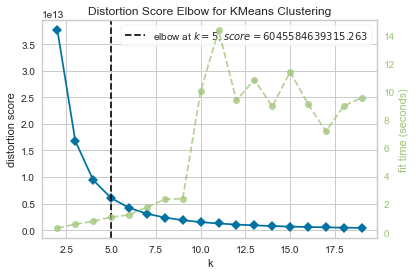

In [10]:

find_k(training_ratings)

In [11]:
# Using k value from the visualizer above
k = 5

# KMeans Clustering

In [12]:

#Training Phase
kmeans = KMeans(n_clusters=k, init = 'k-means++', n_init = 10, random_state = 0)
clusters = kmeans.fit_predict(training_ratings)
#clusters = kmeans.fit(genre_ratings)
clustered_genre_ratings = cluster_labels(training_ratings, kmeans.labels_ )
#Testing phase
predictions, test_data = predict_testset(testing_ratings, kmeans)


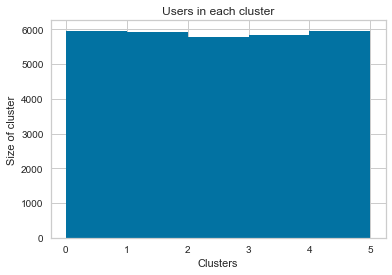

In [13]:

plt.hist(kmeans.labels_, k, [0,k])
plt.title("Users in each cluster")
plt.ylabel("Size of cluster")
plt.xlabel("Clusters")
plt.show()

# BIRCH Clustering

In [20]:
birch = Birch(threshold =0.01, n_clusters=k)
clusters = birch.fit_predict(training_ratings)


In [21]:
clustered_genre_ratings = cluster_labels(training_ratings, birch.labels_ )
predictions, test_data = predict_testset(testing_ratings, birch)

# Agglomerative Clustering

In [ ]:
agglo = AgglomerativeClustering(n_clusters=k, affinity="euclidean", linkage="average")
clusters = agglo.fit_predict(training_ratings)
clustered_genre_ratings = cluster_labels(training_ratings, agglo.labels_ )
predictions, test_data = predict_testset(testing_ratings, agglo)

# MeanShift Clustering

In [23]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(training_ratings)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)


In [24]:
clusters = ms.fit_predict(training_ratings)
clustered_genre_ratings = cluster_labels(training_ratings, ms.labels_ )

In [25]:
predictions, test_data = predict_testset(testing_ratings, ms)

# Clustering results

In [14]:
clustered_genre_ratings

,IMAX,Western,Animation,Action,Horror,Documentary,Sci-Fi,Fantasy,Comedy,Drama,...,Film-Noir,Mystery,Musical,Crime,War,Thriller,Children,Romance,userId,cluster
0,0.0,5.0,3.5,0.00,3.75,0.0,4.000,3.5,4.000000,4.214286,...,0.0,4.25,0.0,4.300000,0.0,3.916667,3.5,4.125,100351,0
1,0.0,3.5,0.0,3.75,0.00,0.0,4.375,4.0,3.642857,3.900000,...,0.0,0.00,4.0,3.833333,0.0,4.500000,4.0,3.750,75251,3
2,0.0,0.0,0.0,0.00,0.00,0.0,0.000,0.0,4.000000,4.666667,...,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,4.000,130058,0
3,0.0,0.0,0.0,0.00,0.00,0.0,5.000,0.0,4.000000,4.666667,...,0.0,5.00,0.0,5.000000,0.0,5.000000,0.0,4.000,157362,4
4,0.0,0.0,0.0,0.00,0.00,0.0,0.000,0.0,4.500000,4.500000,...,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,4.500,113443,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68625,0.0,0.0,4.0,0.00,4.00,0.0,0.000,0.0,4.333333,5.000000,...,0.0,0.00,0.0,0.000000,0.0,4.000000,4.0,0.000,76077,3
68626,0.0,0.0,4.0,0.00,0.00,0.0,0.000,0.0,4.000000,0.000000,...,0.0,0.00,0.0,0.000000,0.0,0.000000,4.0,0.000,88718,3
68627,0.0,0.0,4.0,4.50,0.00,0.0,0.000,5.0,4.333333,4.666667,...,5.0,4.00,0.0,4.500000,0.0,4.000000,4.0,4.000,99051,0
68628,0.0,0.0,5.0,4.00,4.00,0.0,4.000,0.0,4.500000,0.000000,...,0.0,0.00,0.0,0.000000,0.0,4.000000,5.0,0.000,128874,0


In [15]:
user_cluster = clustered_genre_ratings [["userId", "cluster"]]

In [16]:
test_data

,Crime,Documentary,War,Comedy,Drama,Thriller,Western,Action,Adventure,Children,Romance,Film-Noir,Mystery,Animation,Horror,Sci-Fi,Fantasy,Musical,userId,cluster
0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.00,4.00,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,72073,0
1,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.00,3.50,3.5,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,145395,4
2,0.0,0.0,0.0,4.0,0.0,3.5,0.0,3.75,3.75,4.0,0.0,0.0,0.0,4.0,0.0,4.0,3.5,0.0,75891,0
3,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.00,4.50,4.5,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,81944,0
4,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.00,4.00,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,18476,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29408,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5308,2
29409,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15878,2
29410,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18441,2
29411,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67730,0


In [17]:
all_ratings = clustered_genre_ratings.append(test_data)

In [18]:
# Append both training and testing sets to a single one

clusters = np.append(clusters, predictions)
users = np.array(users, dtype= np.int64)
clusters = np.array(clusters, dtype= np.int64)


In [19]:
# concatenate users and clusters
users_cluster = pd.DataFrame(np.concatenate((users.reshape(-1,1), clusters.reshape(-1,1)), axis = 1), columns = ['userId', 'Cluster'])
users_cluster.T

,0,1,2,3,4,5,6,7,8,9,...,98033,98034,98035,98036,98037,98038,98039,98040,98041,98042
userId,100351,75251,130058,157362,113443,103804,90742,3551,26501,133115,...,51432,1434,103298,25450,417,5308,15878,18441,67730,151168
Cluster,0,3,0,4,0,0,3,2,2,4,...,3,2,1,2,2,2,2,2,0,4


In [20]:
cluster_movies = clusters_movies(users_cluster, movie_ratings)
#print(cluster_movies)
# Movies in cluster 1
cluster_movies[1].T

,0,1,2,3,4,5,6,7,8,9,...,644,645,646,647,648,649,650,651,652,653
movieId,2571,858,2028,1270,1291,1089,2329,1213,780,1206,...,1316,1575,1324,4209,2873,1335,3782,1490,1522,8845
Count,2444,1782,1571,1490,1223,1157,1148,1096,1044,975,...,1,1,1,1,1,1,1,1,1,1


In [21]:
all_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98043 entries, 0 to 29412
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   IMAX         68630 non-null  float64
 1   Western      98043 non-null  float64
 2   Animation    98043 non-null  float64
 3   Action       98043 non-null  float64
 4   Horror       98043 non-null  float64
 5   Documentary  98043 non-null  float64
 6   Sci-Fi       98043 non-null  float64
 7   Fantasy      98043 non-null  float64
 8   Comedy       98043 non-null  float64
 9   Drama        98043 non-null  float64
 10  Adventure    98043 non-null  float64
 11  Film-Noir    98043 non-null  float64
 12  Mystery      98043 non-null  float64
 13  Musical      98043 non-null  float64
 14  Crime        98043 non-null  float64
 15  War          98043 non-null  float64
 16  Thriller     98043 non-null  float64
 17  Children     98043 non-null  float64
 18  Romance      98043 non-null  float64
 19  user

In [22]:
all_users_cluster = all_ratings.replace(np.nan,0)
all_users_cluster

,IMAX,Western,Animation,Action,Horror,Documentary,Sci-Fi,Fantasy,Comedy,Drama,...,Film-Noir,Mystery,Musical,Crime,War,Thriller,Children,Romance,userId,cluster
0,0.0,5.0,3.5,0.00,3.75,0.0,4.000,3.5,4.000000,4.214286,...,0.0,4.25,0.0,4.300000,0.0,3.916667,3.5,4.125,100351,0
1,0.0,3.5,0.0,3.75,0.00,0.0,4.375,4.0,3.642857,3.900000,...,0.0,0.00,4.0,3.833333,0.0,4.500000,4.0,3.750,75251,3
2,0.0,0.0,0.0,0.00,0.00,0.0,0.000,0.0,4.000000,4.666667,...,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,4.000,130058,0
3,0.0,0.0,0.0,0.00,0.00,0.0,5.000,0.0,4.000000,4.666667,...,0.0,5.00,0.0,5.000000,0.0,5.000000,0.0,4.000,157362,4
4,0.0,0.0,0.0,0.00,0.00,0.0,0.000,0.0,4.500000,4.500000,...,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,4.500,113443,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29408,0.0,0.0,0.0,0.00,0.00,0.0,0.000,0.0,0.000000,4.000000,...,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.000,5308,2
29409,0.0,0.0,0.0,0.00,0.00,0.0,0.000,0.0,0.000000,5.000000,...,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.000,15878,2
29410,0.0,0.0,0.0,0.00,0.00,0.0,0.000,0.0,4.000000,0.000000,...,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.000,18441,2
29411,0.0,0.0,0.0,0.00,0.00,0.0,0.000,0.0,0.000000,4.000000,...,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.000,67730,0


In [26]:
        
count_cluster_users(users_cluster, k)

Clusters       No. of Users
Cluster 0 -->  19797
Cluster 1 -->  19648
Cluster 2 -->  19634
Cluster 3 -->  19456
Cluster 4 -->  19508


In [23]:
user_cluster = all_ratings[["userId", "cluster"]]
user_cluster


,userId,cluster
0,100351,0
1,75251,3
2,130058,0
3,157362,4
4,113443,0
...,...,...
29408,5308,2
29409,15878,2
29410,18441,2
29411,67730,0


In [26]:
# group by cluster id
for i in range (5):
    data_cluster = all_users_cluster[all_users_cluster['cluster'] == i]
    file_name = "cluster_"+ str(i) +".csv"
    if not os.path.isfile("./datasets/"+file_name):
        data_cluster.to_csv("./datasets/"+file_name)

In [27]:

count_cluster_movies(cluster_movies)

Clusters       No. of Movies
Cluster 0 -->  662
Cluster 1 -->  654
Cluster 2 -->  660
Cluster 3 -->  672
Cluster 4 -->  670


In [28]:

class saveFiles:
    def save(self, filename, data):
        try:
            file = open('datasets/' + filename + '.pkl', 'wb')
            pickle.dump(data, file)
        except:
            err = 'Error: {0}, {1}'.format(exc_info()[0], exc_info()[1])
            print(err)
            file.close()
            return [False, err]
        else:
            file.close()
            return [True]
      
    def saveClusterMoviesDataset(self, data):
        return self.save('clusters_movies_dataset', data)
    
    def saveUsersClusters(self, data):
        return self.save('users_clusters', data)


In [29]:
file_handler = saveFiles()
print(file_handler.saveClusterMoviesDataset(cluster_movies))
print(file_handler.saveUsersClusters(users_cluster))

[True]
[True]
